#  library

main() 함수 내 crawler() 함수 수행

In [1]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [2]:
cos = []

In [103]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
  list_keyword = ['적수']
  for keyword in list_keyword:
    query = region +' ' + keyword
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
        atags = soup.find_all('a', 'news_tit')
        for atag in atags:
            title = atag.get('title')
            title_text.append(title)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출 (a 태그 중 class 명이 info press인 것)
        source_lists = soup.find_all('a', 'info press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
        contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화

        #모든 리스트 딕셔너리형태로 저장
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 1
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                                        title source  \
0           '연애의 맛2' 시청률 4.7% 기록…동시간대 적수없는 1위  TV리포트   
1                 붉은 수돗물 피해 인천 서구 주민들 집단소송 예고   노컷뉴스   
2                '적수 사태 진상규명' 인천시의회 특위 행정사무조사   경인일보   
3               인천시, 수돗물 원수 냄새 물질 증가…"끓여 마셔야"    OBS   
4               ‘붉은 수돗물’ 피해보상 12∼30일 접수 [인천시]   경향신문   
5          '적수피해보상' 현장 접수처 182곳… 인천시 행정공백 불가피   경인일보   
6                인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐   중부일보   
7  인천시, 부동산 시장 침체로 취득세 감소로 올 세수 1천246억원 세수 구멍   경기일보   
8           인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수   경향신문   
9                   인천 공촌정수장 탁도계 업체 "고장 안 났다"  인천투데이   

                                            contents  \
0  지난 15일 방송된 '연애의 맛2' 12회는 닐슨코리아 기준 전국 시청률 4.7%를...   
1  현재 적수 피해지역인 인천 서구 연희·검암·경서·검단· 지역의 불량배관은 47%다....   
2  13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...   
3  앞서 적수 사태를 겪은 인천 서구와 강화군, 영종도에 수돗물을 공급하는 공촌정수장의...   
4  인천시는 지난 5월30일부터 지난 4일까지 적수 사태로 피해를 인천 서

In [104]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_11936/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0     지난 15일 방송된 '연애의 맛2' 12회는 닐슨코리아 기준 전국 시청률 4.7%를...
1     현재 적수 피해지역인 인천 서구 연희·검암·경서·검단· 지역의 불량배관은 47%다....
2     13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...
3     앞서 적수 사태를 겪은 인천 서구와 강화군, 영종도에 수돗물을 공급하는 공촌정수장의...
4     인천시는 지난 5월30일부터 지난 4일까지 적수 사태로 피해를 인천 서구와 중구 영...
5     인천시가 19일부터 시청 직원 600여 명을 투입해 붉은 수돗물 사태 피해 보상 현...
6     윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...
7     '붉은 수돗물(적수)' 민원 해결을 위해 상수도사업특별회계 자본 예비비 600억원을...
8     인천시는 지난 5월30일 발생한 적수 사태로 피해를 본 주민들을 대상으로 지난 12...
9     인천 수돗물 적수(붉은 물) 사태의 원인 중 하나인 서구 공촌정수장의 탁도계 고장이...
10                                                인천 적수
dtype: object

In [105]:
df

,title,source,contents,link
0,'연애의 맛2' 시청률 4.7% 기록…동시간대 적수없는 1위,TV리포트,지난 15일 방송된 '연애의 맛2' 12회는 닐슨코리아 기준 전국 시청률 4.7%를...,https://www.tvreport.co.kr/2003056
1,붉은 수돗물 피해 인천 서구 주민들 집단소송 예고,노컷뉴스,현재 적수 피해지역인 인천 서구 연희·검암·경서·검단· 지역의 불량배관은 47%다....,https://www.nocutnews.co.kr/news/5196447
2,'적수 사태 진상규명' 인천시의회 특위 행정사무조사,경인일보,13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...,http://www.kyeongin.com/main/view.php?key=2019...
3,"인천시, 수돗물 원수 냄새 물질 증가…""끓여 마셔야""",OBS,"앞서 적수 사태를 겪은 인천 서구와 강화군, 영종도에 수돗물을 공급하는 공촌정수장의...",http://www.obsnews.co.kr/news/articleView.html...
4,‘붉은 수돗물’ 피해보상 12∼30일 접수 [인천시],경향신문,인천시는 지난 5월30일부터 지난 4일까지 적수 사태로 피해를 인천 서구와 중구 영...,http://news.khan.co.kr/kh_news/khan_art_view.h...
5,'적수피해보상' 현장 접수처 182곳… 인천시 행정공백 불가피,경인일보,인천시가 19일부터 시청 직원 600여 명을 투입해 붉은 수돗물 사태 피해 보상 현...,http://www.kyeongin.com/main/view.php?key=2019...
6,"인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐",중부일보,윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...,http://www.joongboo.com/news/articleView.html?...
7,"인천시, 부동산 시장 침체로 취득세 감소로 올 세수 1천246억원 세수 구멍",경기일보,'붉은 수돗물(적수)' 민원 해결을 위해 상수도사업특별회계 자본 예비비 600억원을...,http://www.kyeonggi.com/news/articleView.html?...
8,인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수,경향신문,인천시는 지난 5월30일 발생한 적수 사태로 피해를 본 주민들을 대상으로 지난 12...,http://news.khan.co.kr/kh_news/khan_art_view.h...
9,"인천 공촌정수장 탁도계 업체 ""고장 안 났다""",인천투데이,인천 수돗물 적수(붉은 물) 사태의 원인 중 하나인 서구 공촌정수장의 탁도계 고장이...,http://www.incheontoday.com/news/articleView.h...


# 벡터화

In [106]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [107]:
tfidfv_array

array([[0.        , 0.        , 0.16625633, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.1443119 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.30682468, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 유사도

In [108]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.004134,0.004138,0.004650,0.035348,0.000000,0.004658,0.024575,0.056486,0.003867,0.037346
1,0.004134,1.000000,0.004082,0.035890,0.012392,0.027444,0.035948,0.004166,0.004198,0.039896,0.110689
2,0.004138,0.004082,1.000000,0.004592,0.004129,0.085177,0.049083,0.077013,0.004202,0.059312,0.036879
3,0.004650,0.035890,0.004592,1.000000,0.058659,0.000000,0.015529,0.004686,0.004722,0.033572,0.124518
4,0.035348,0.012392,0.004129,0.058659,1.000000,0.117476,0.013962,0.004213,0.237789,0.011591,0.111950
5,0.000000,0.027444,0.085177,0.000000,0.117476,1.000000,0.020127,0.040639,0.060641,0.096220,0.000000
6,0.004658,0.035948,0.049083,0.015529,0.013962,0.020127,1.000000,0.016082,0.004730,0.023340,0.124716
7,0.024575,0.004166,0.077013,0.004686,0.004213,0.040639,0.016082,1.000000,0.004288,0.036551,0.037636
8,0.056486,0.004198,0.004202,0.004722,0.237789,0.060641,0.004730,0.004288,1.000000,0.003927,0.037925
9,0.003867,0.039896,0.059312,0.033572,0.011591,0.096220,0.023340,0.036551,0.003927,1.000000,0.103539


In [109]:
len_contents = len(cos_sim_df)-1
len_contents

10

In [110]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

10    1.000000
6     0.124716
3     0.124518
4     0.111950
1     0.110689
9     0.103539
8     0.037925
7     0.037636
0     0.037346
2     0.036879
5     0.000000
Name: 10, dtype: float64

In [111]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

7.251985408098858


In [112]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[0.0,
 1.603609031248817,
 6.899689567374691,
 8.804377789527338,
 11.1853328498195,
 6.996974896240077,
 9.786849482847176,
 5.579251564759708,
 7.138334768644464,
 7.251985408098858]

In [113]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,0.000000
1,1.603609
2,6.899690
3,8.804378
4,11.185333
5,6.996975
6,9.786849
7,5.579252
8,7.138335
9,7.251985


# 시각화

In [114]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

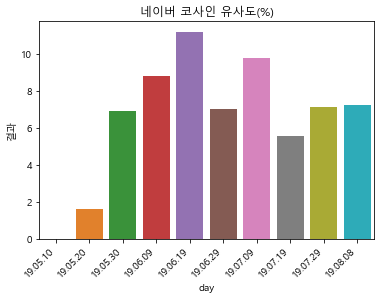

In [115]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")

In [116]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
list_search

'인천 적수'